# Toonify

In [ ]:
# Mount your drive first

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!rm -rf /content/stylegan2

In [2]:
# Clone this to your own github and change link to your own

!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2


In [3]:
!nvcc test_nvcc.cu -o test_nvcc -run

CPU says hello.
GPU says hello.


In [4]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [5]:
# Upload your face

def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

upload_files()

Saving 000406.jpg to 000406.jpg
Saving 000442.jpg to 000442.jpg
Saving 001743.jpg to 001743.jpg
Saving 004526.jpg to 004526.jpg
Saving 008149.jpg to 008149.jpg
Saving 025001.jpg to 025001.jpg
Saving kalki1.jpg to kalki1.jpg
Saving kalki2.jpg to kalki2.jpg


['000406.jpg',
 '000442.jpg',
 '001743.jpg',
 '004526.jpg',
 '008149.jpg',
 '025001.jpg',
 'kalki1.jpg',
 'kalki2.jpg']

In [6]:
# Move image to /raw

!mv "/content/stylegan2/kalki2.jpg" "/content/stylegan2/raw/"

In [7]:
# Download their models and upoad to your own drive also

import pretrained_networks

# Dowwnload both link below and upload to colab
# blended_url = "https://drive.google.com/uc?export=download&id=1_qSp9-lZZnowpg8ERZmSuuD-U_uyjKQp" 
# ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

In [8]:
!cp /content/drive/MyDrive/FaceGAN/code/model/ffhq-cartoon-blended-64.pkl -d /content/

In [9]:
!cp /content/drive/MyDrive/FaceGAN/code/model/stylegan2-ffhq-config-f.pkl -d /content/

In [10]:
blended_url = "/content/ffhq-cartoon-blended-64.pkl" 
ffhq_url = "/content/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [11]:
# Start toonify

!python align_images.py raw aligned

64045056/64040097 [==============================] - 1s 0us/step


In [12]:
!zip -r /content/file.zip /content/stylegan2/aligned

  adding: content/stylegan2/aligned/ (stored 0%)
  adding: content/stylegan2/aligned/008149_01.png (deflated 0%)
  adding: content/stylegan2/aligned/000406_01.png (deflated 0%)
  adding: content/stylegan2/aligned/kalki2_01.png (deflated 0%)
  adding: content/stylegan2/aligned/004526_01.png (deflated 0%)
  adding: content/stylegan2/aligned/025001_01.png (deflated 0%)
  adding: content/stylegan2/aligned/000442_01.png (deflated 0%)
  adding: content/stylegan2/aligned/kalki1_01.png (deflated 0%)
  adding: content/stylegan2/aligned/001743_01.png (deflated 0%)


In [43]:
!rm -rf /content/stylegan2/generated

In [44]:
# Change num-steps parameter to try different values, Lower=Faster but low quality, Higher=Slower but high quality
# --num-steps=1000 --initial-learning-rate=0.1 --initial-noise-factor=0.05 

!python project_images.py --num-steps=500 --initial-noise-factor=0.025 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "000406_01.png"...
0 / 500 ... 2022-04-24 00:08:43.654208: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GAR

In [45]:
# Change minibatch_size parameter to different values

import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=16)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


In [47]:
!zip -r /content/generated_0.025.zip /content/stylegan2/generated

  adding: content/stylegan2/generated/ (stored 0%)
  adding: content/stylegan2/generated/kalki1_01.npy (deflated 7%)
  adding: content/stylegan2/generated/000442_01.npy (deflated 7%)
  adding: content/stylegan2/generated/000406_01-toon.jpg (deflated 4%)
  adding: content/stylegan2/generated/000442_01-toon.jpg (deflated 2%)
  adding: content/stylegan2/generated/008149_01-toon.jpg (deflated 5%)
  adding: content/stylegan2/generated/025001_01.npy (deflated 7%)
  adding: content/stylegan2/generated/008149_01.png (deflated 0%)
  adding: content/stylegan2/generated/000406_01.png (deflated 0%)
  adding: content/stylegan2/generated/kalki2_01.png (deflated 0%)
  adding: content/stylegan2/generated/004526_01.png (deflated 0%)
  adding: content/stylegan2/generated/008149_01.npy (deflated 7%)
  adding: content/stylegan2/generated/000406_01.npy (deflated 7%)
  adding: content/stylegan2/generated/001743_01.npy (deflated 7%)
  adding: content/stylegan2/generated/004526_01-toon.jpg (deflated 2%)
  add

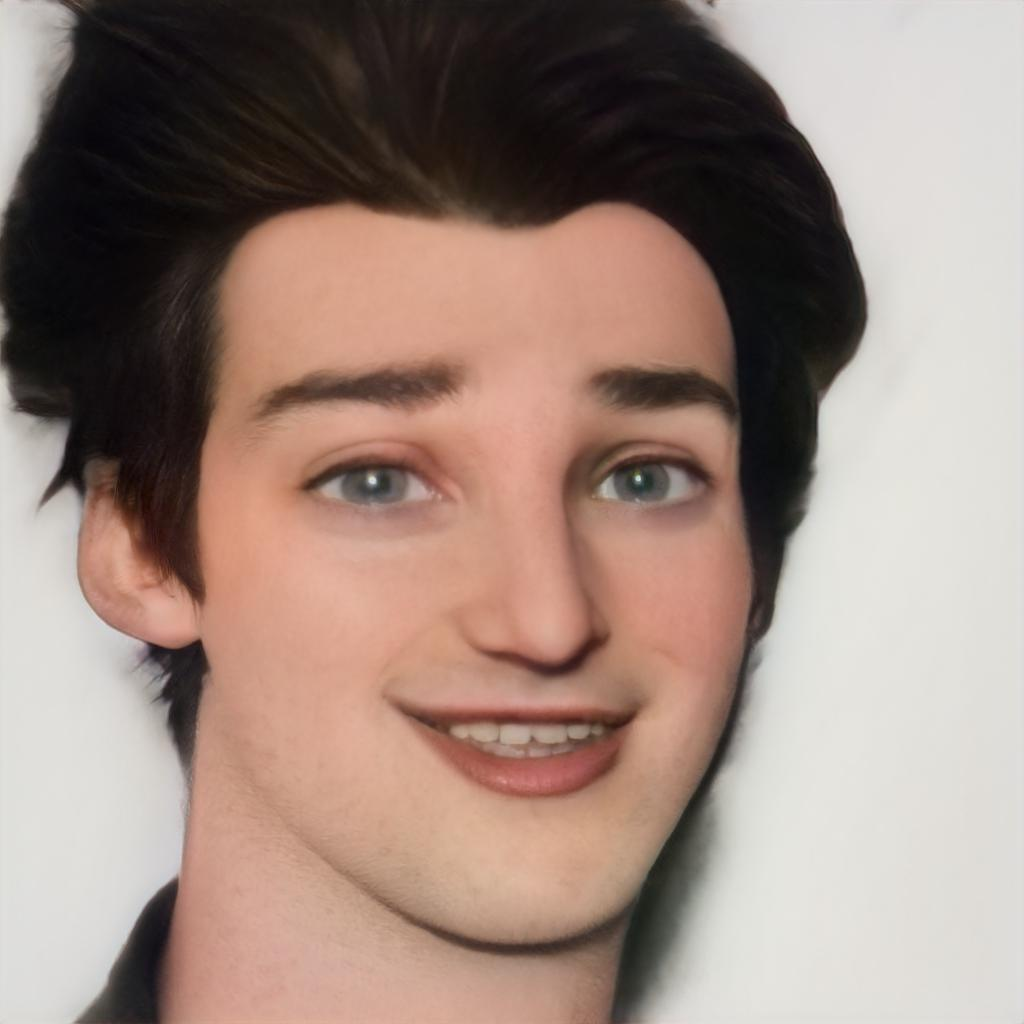

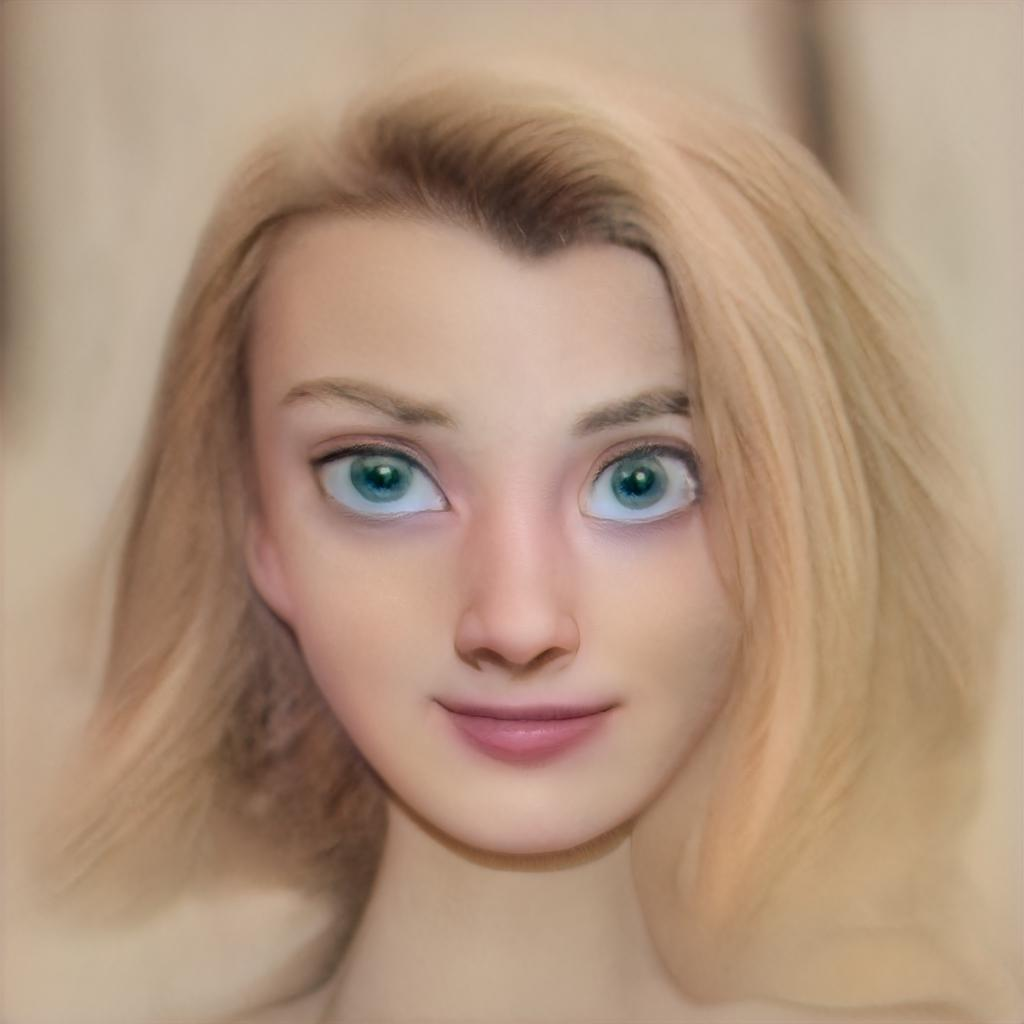

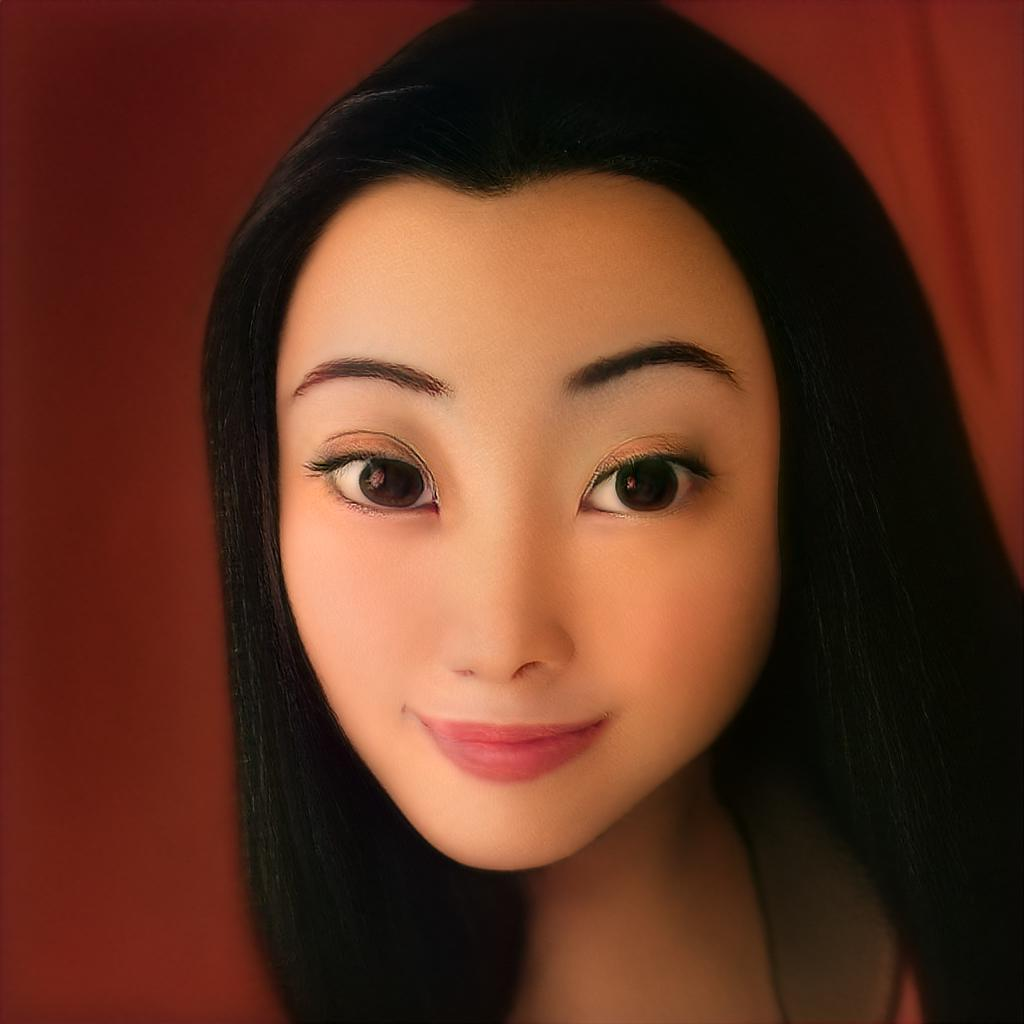

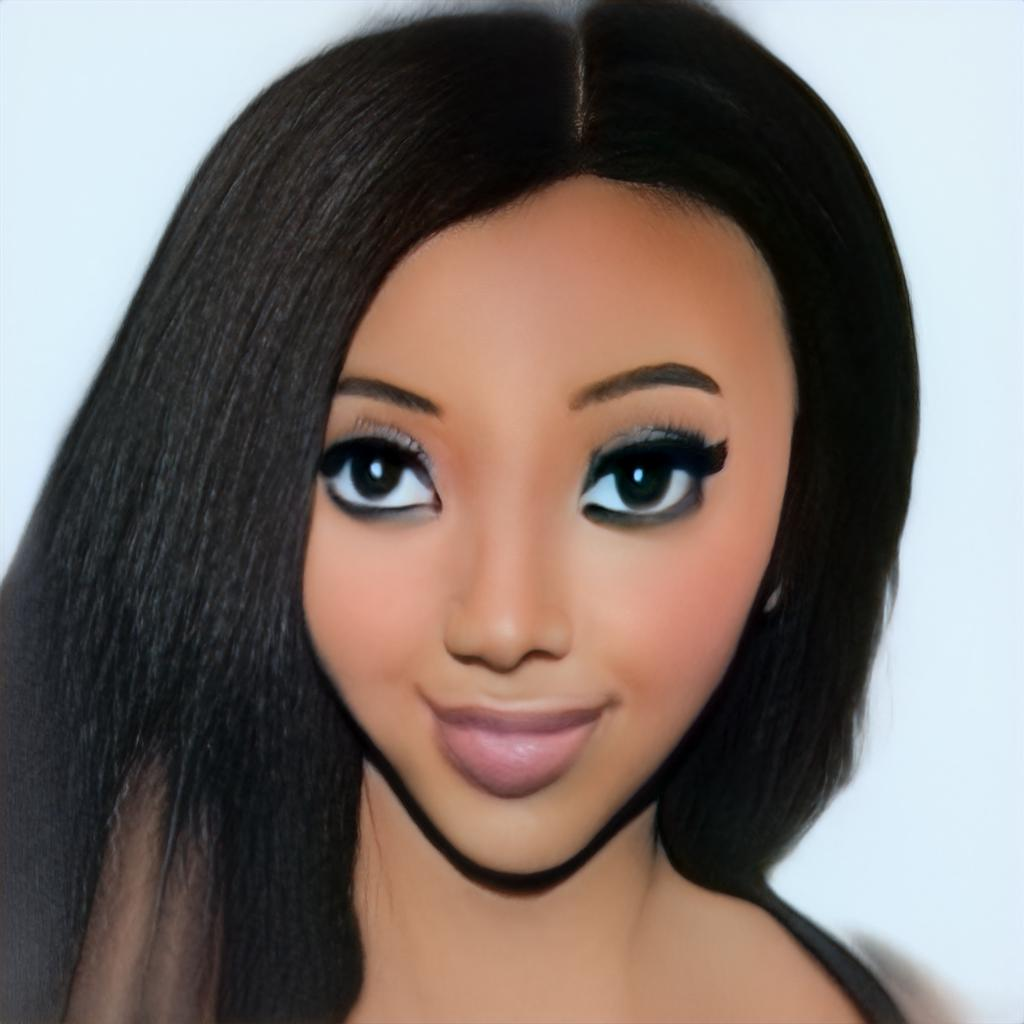

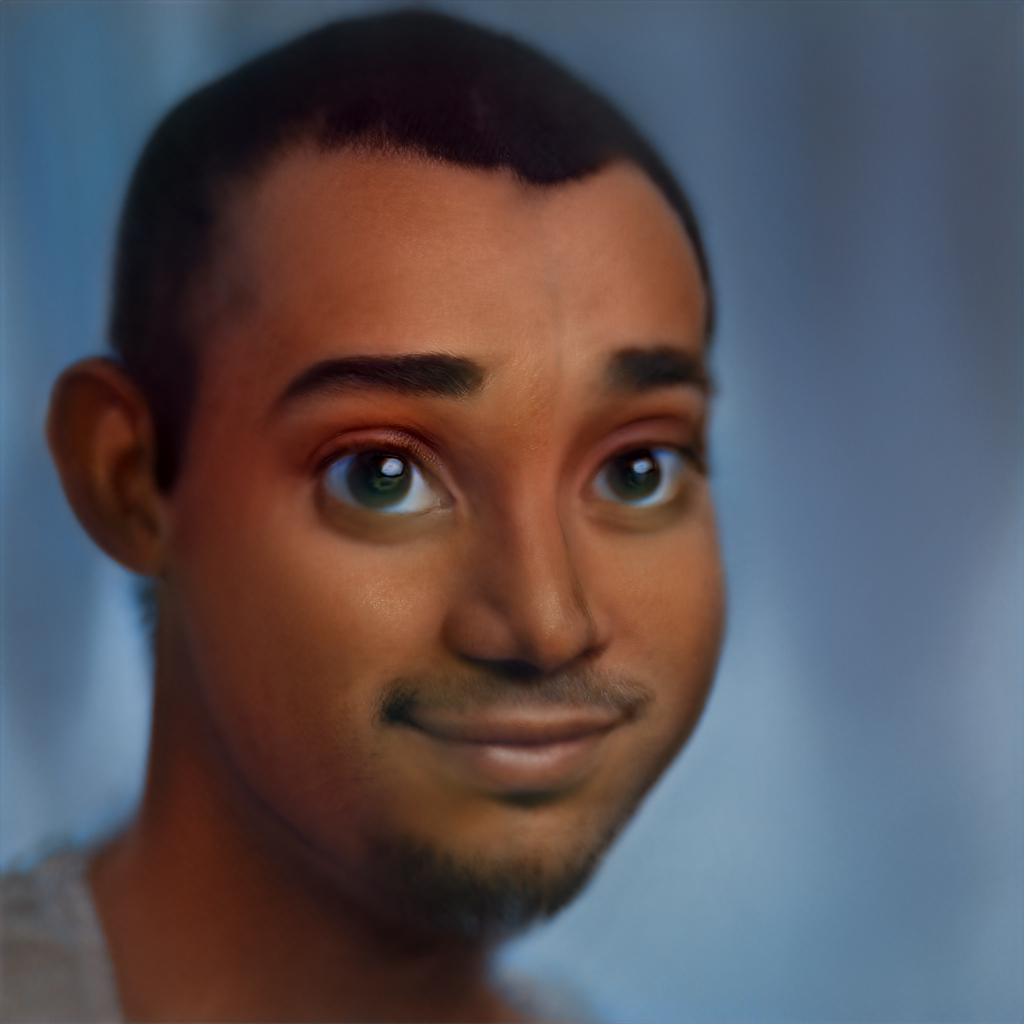

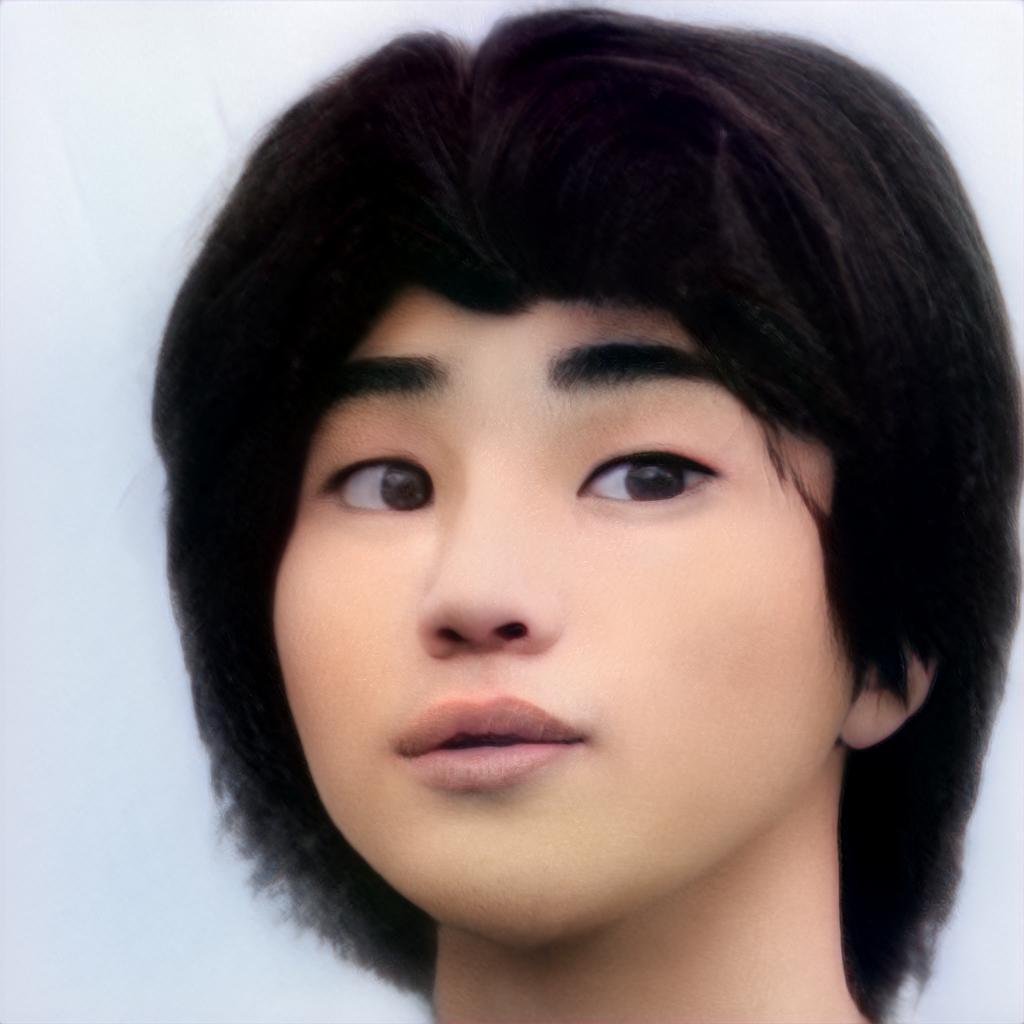

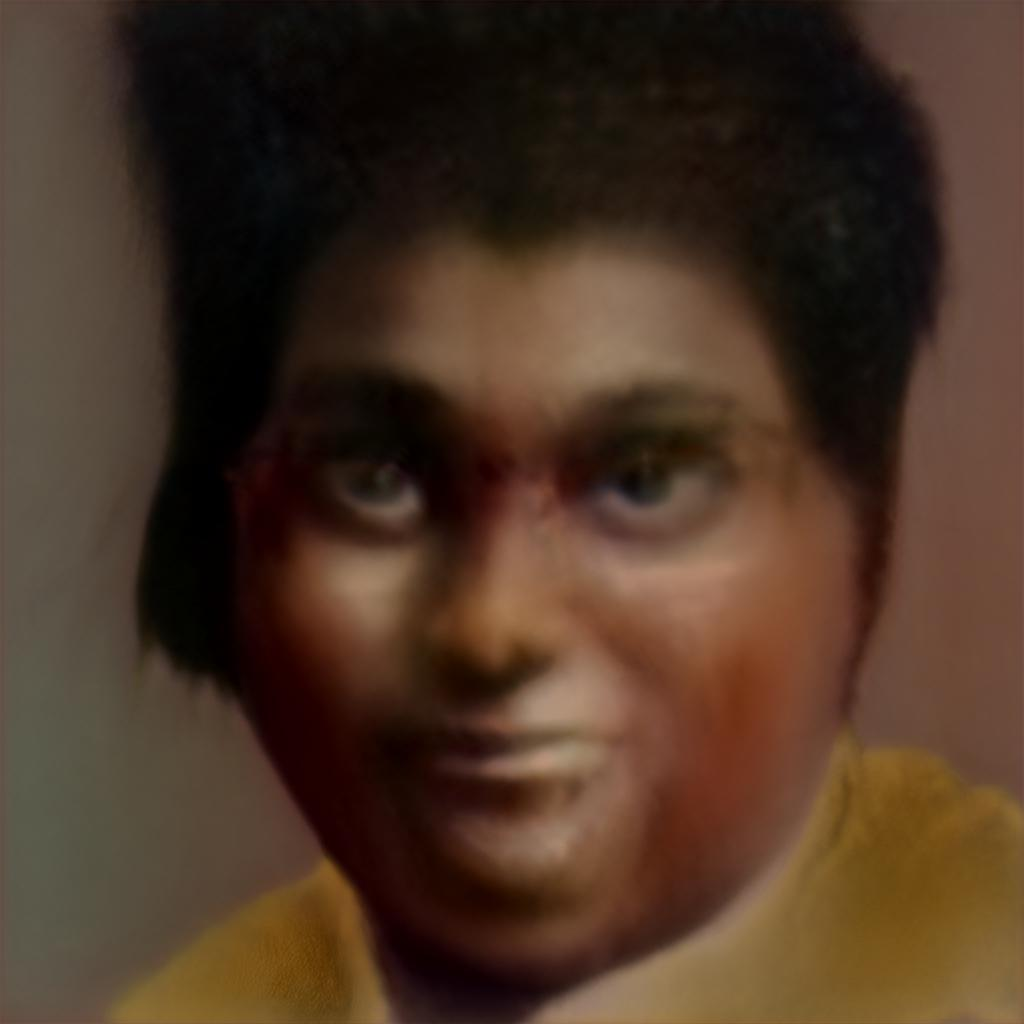

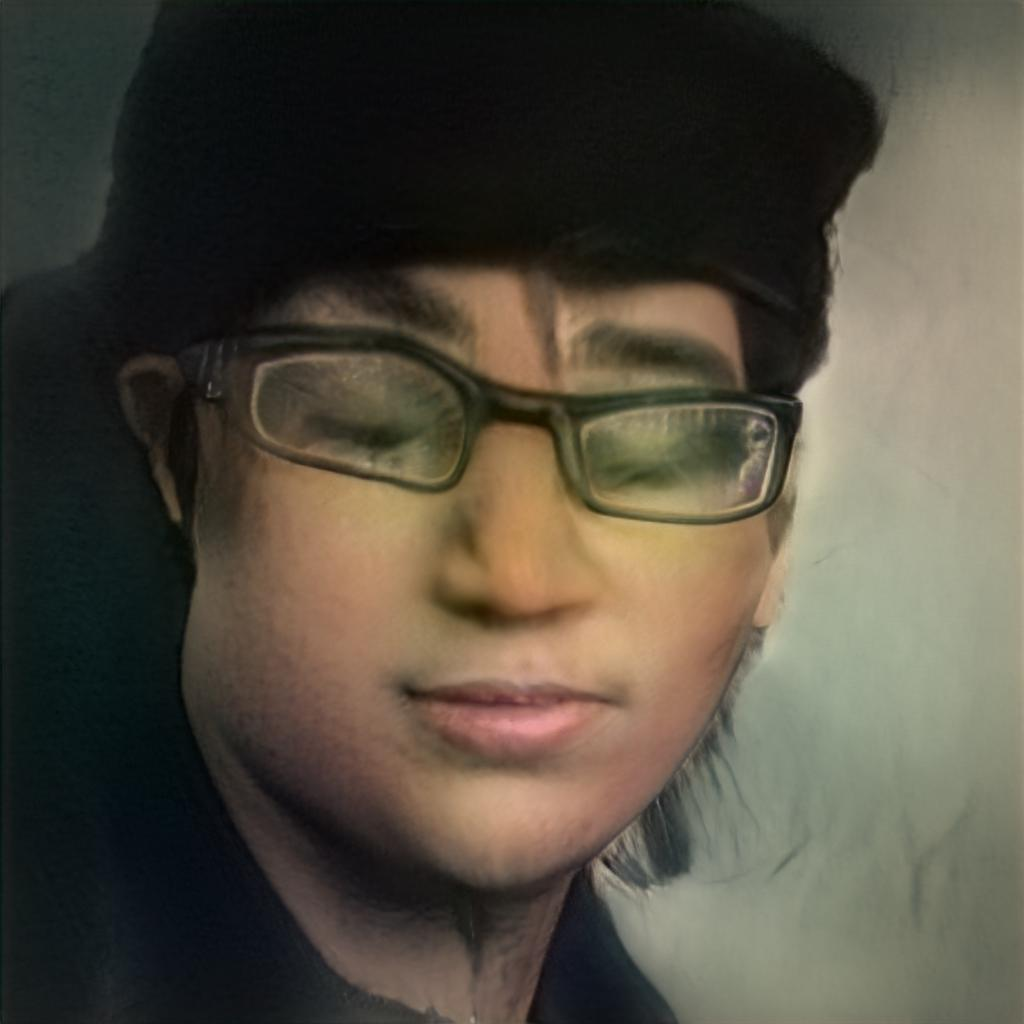

In [17]:
from IPython.display import Image 

tooned = Image(filename="/content/stylegan2/generated/000406_01-toon.jpg", width=256)
display(tooned)

tooned2 = Image(filename="/content/stylegan2/generated/000442_01-toon.jpg", width=256)
display(tooned2)

tooned3 = Image(filename="/content/stylegan2/generated/001743_01-toon.jpg", width=256)
display(tooned3)

tooned4 = Image(filename="/content/stylegan2/generated/004526_01-toon.jpg", width=256)
display(tooned4)

tooned5 = Image(filename="/content/stylegan2/generated/008149_01-toon.jpg", width=256)
display(tooned5)

tooned6 = Image(filename="/content/stylegan2/generated/025001_01-toon.jpg", width=256)
display(tooned6)

tooned7 = Image(filename="/content/stylegan2/generated/kalki1_01-toon.jpg", width=256)
display(tooned7)

tooned8 = Image(filename="/content/stylegan2/generated/kalki2_01-toon.jpg", width=256)
display(tooned8)

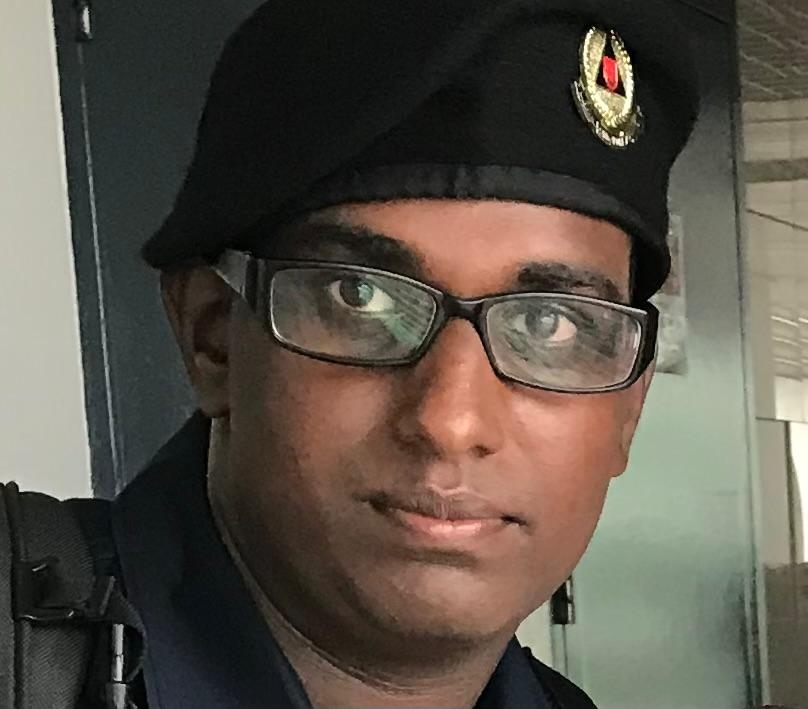

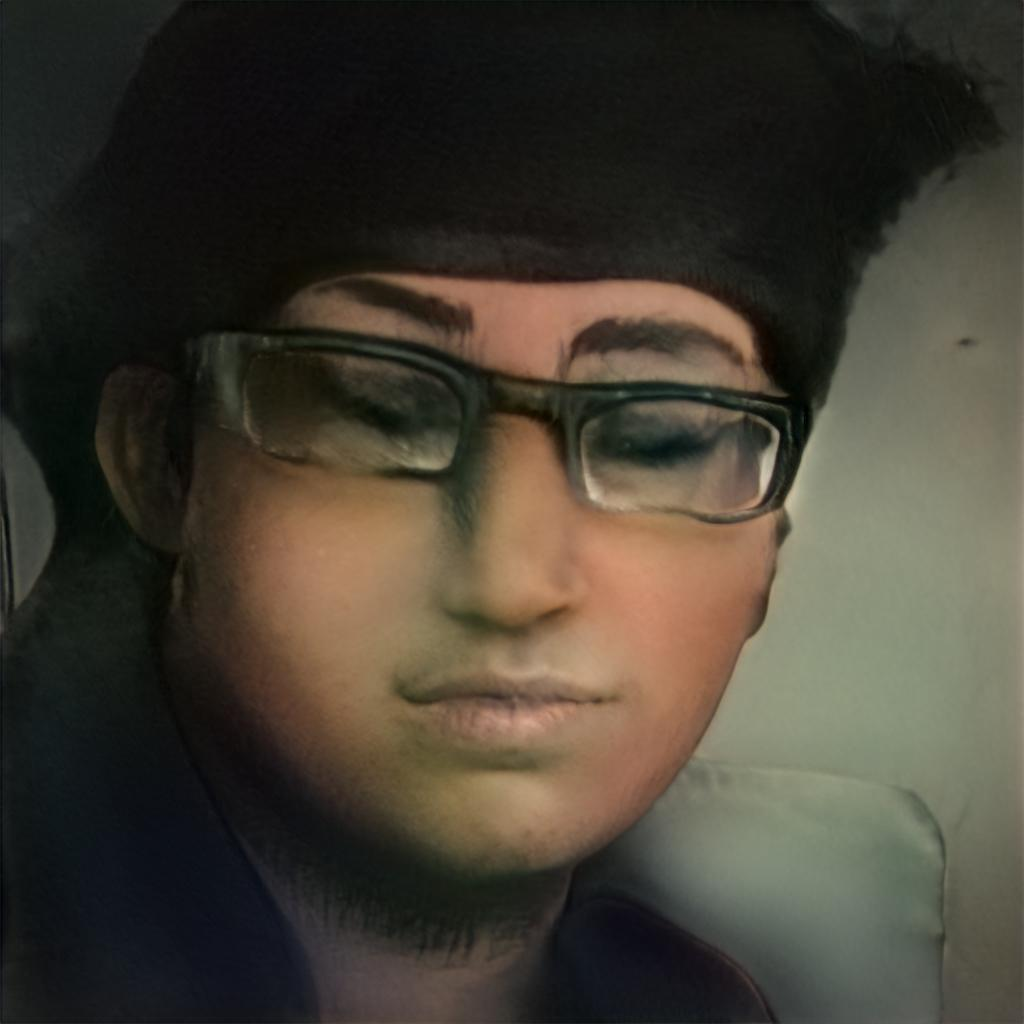

In [ ]:
from IPython.display import Image 
embedded = Image(filename="/content/stylegan2/raw/kalki2.jpg", width=256)
display(embedded)
tooned = Image(filename="/content/stylegan2/generated/kalki2_01-toon.jpg", width=256)
display(tooned)

# First Order Motion 

In [55]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 299, done.
remote: Total 299 (delta 0), reused 0 (delta 0), pack-reused 299
Receiving objects: 100% (299/299), 72.15 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [56]:
cd first-order-model

/content/stylegan2/first-order-model


In [ ]:
# Download and upload to your drive

# https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing

In [48]:
!mkdir /content/toonified_images/

In [50]:
!cp -r /content/drive/MyDrive/FaceGAN/output_images/generated_1000 -d /content/toonified_images/

In [ ]:
# Copying model over

!cp /content/drive/MyDrive/FaceGAN/driver_video/vox-cpk.pth.tar -d /content/

In [5]:
# This is where you load the model to do animation

# Change checkpoint_path to the model path
from demo import load_checkpoints

generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='/content/vox-cpk.pth.tar')


In [17]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Your source image will be the toonified image
source_image = imageio.imread('/content/toonified_images/generated_1000/kalki2_01-toon.jpg')
# This video will be what you want your toonified image to be animated
reader = imageio.get_reader('/content/drive/MyDrive/FaceGAN/driver_video/10.mp4')

#Resize image and video to 256x256
source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
# HTML(display(source_image, driving_video).to_html5_video())
# Left is your source image, Right is your driver video

In [18]:
from demo import make_animation
from skimage import img_as_ubyte

# 1) 
# Relative coordinates
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

#save resulting video
imageio.mimsave('/content/generated_video.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
#video can be downloaded from /content folder

HTML(display(source_image, driving_video, predictions).to_html5_video())


100%|██████████| 444/444 [00:18<00:00, 24.46it/s]


In [ ]:
# 2)
# Absolute coordinates
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=False, adapt_movement_scale=True)
HTML(display(source_image, driving_video, predictions).to_html5_video())